In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from scipy import stats
from scipy.stats import rankdata
from sklearn.preprocessing import QuantileTransformer

# Music Genre Classification Project

## Target Variable
- **Class**: Genre of the track (target variable for classification).

## Features
### Numerical
- **popularity**: A measure of the song's popularity. Higher values indicate more popular songs.
- **danceability**: A measure from 0.0 to 1.0 indicating how suitable a track is for dancing. It's based on a combination of musical elements including tempo and rhythm.
- **energy**: A measure from 0.0 to 1.0 representing the perceived intensity and activity of the track.
- **loudness**: The overall loudness of the track in decibels (dB). Values are averaged across the entire track.
- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g., sad, depressed, angry).
- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- **duration**: The duration of the track in milliseconds.

### Categorical
- **key**: The key of the track, represented as integers mapping to pitch classes (0 = C, 1 = C♯/D♭, 2 = D, etc.).
- **mode**: Indicates the modality (major or minor) of a track. Major is represented by 1 and minor by 0.
- **time_signature**: A notational convention used in Western musical notation to specify how many beats (pulses) are contained in each measure (bar), and which note value is equivalent to a beat.

### Text Data
- **Artist Name**
- **Track Name** (these might not be directly used in the model but could be useful for analysis)


# The Data

## This code fill most of the missing values using Spotipy library

```python
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
from spotipy.exceptions import SpotifyException
class SpotifyDataHandler:

  __client_id = '9015277f9e524a9abbd2d4cedf2827e7'
  __client_secret = '624f96eeeabe4b03af75c377f8a7704a'

  def _init_(self):
    self.client_credentials_manager = SpotifyClientCredentials(client_id=self._client_id, client_secret=self._client_secret)
    self.sp = spotipy.Spotify(client_credentials_manager=self.client_credentials_manager)
    self.track_cache = {}

  def search_song(self, artist_track_pairs):
    queries = [f"{artist} {track}" for artist, track in artist_track_pairs]
    track_results = {}
    for query in queries:
      if query in self.track_cache:
        track_results[query] = self.track_cache[query]
      else:
        result = self.sp.search(q=query, type='track', limit=1)
        if result['tracks']['items']:
            track = result['tracks']['items'][0]
            track_results[query] = track
            self.track_cache[query] = track
        else:
            track_results[query] = None
            self.track_cache[query] = None
    return track_results

  def get_release_year(self, tracks):
    release_years = []
    for track in tracks:
      if track and 'album' in track and 'release_date' in track['album']:
        release_date = track['album']['release_date']
        year = release_date.split('-')[0]
        release_years.append(year)
      else:
        release_years.append(None)
    return release_years

  def get_features(self, track_ids):
    try:
      time.sleep(2)
      features = self.sp.audio_features(track_ids)
      return features
    except Exception as e:
      if e.http_status == 429:
        print(f"Rate limit exceeded. Retrying ")
    return features
def fill_missing_values(df):
  song = SpotifyDataHandler()
  track_ids = []
  index_map = {}
  popularity_map = {}

  # Collect track ids and corresponding DataFrame indices
  for index, row in df.iterrows():
    if pd.isna(df.at[index, 'key']) or pd.isna(df.at[index, 'instrumentalness']) or pd.isna(df.at[index, 'Popularity']):
      track = song.search_song(row['Artist Name'], row['Track Name'])
      if track:
        track_ids.append(track['id'])
        index_map[track['id']] = index
        popularity_map[track['id']] = track['popularity']

  # Batch process track ids
  for i in range(0, len(track_ids), 100):
    batch = track_ids[i:i+100]
    features_list = song.get_features(batch)
    # Update DataFrame with features
    for features in features_list:
      index = index_map[features['id']]
      df.at[index, 'key'] = features['key']
      df.at[index, 'instrumentalness'] = features['instrumentalness']
      df.at[index, 'Popularity'] = popularity_map[features['id']]

  return df
```

In [12]:
# df = pd.read_csv('train.csv')
df = pd.read_csv('missing_filled_train.csv')
df

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,0.000000,0.1060,0.235,152.429,204947.000000,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.046800,0.1040,0.380,132.921,191956.000000,4,6
2,3,Royal & the Serpent,phuck u,NaN,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.635000,0.2840,0.635,159.953,161037.000000,4,10
3,4,Detroit Blues Band,Missing You,12.0,0.515,0.308,0.0,-14.711,1,0.0312,0.907000,0.021300,0.3000,0.501,172.472,298093.000000,3,2
4,5,Coast Contra,My Lady,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,0.000000,0.2110,0.619,88.311,254145.000000,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14391,14392,NOISY,I Wish I Was A...,47.0,0.607,0.946,1.0,-2.965,1,0.1500,0.005480,0.000390,0.2780,0.653,120.011,195181.000000,4,10
14392,14393,BLOODSPOT,Deadline Story (feat. Patrick Boos),27.0,0.435,0.951,8.0,-7.475,1,0.0576,0.000005,0.550000,0.0952,0.203,135.034,282043.000000,4,8
14393,14394,Cold Years,Too Far Gone,22.0,0.415,0.941,11.0,-4.300,1,0.0524,0.001810,0.000004,0.3370,0.572,167.978,176529.000000,4,10
14394,14395,The Jaded Hearts Club,Reach Out I'll Be There,37.0,0.493,0.986,1.0,-2.279,1,0.0917,0.000967,0.006620,0.1230,0.567,122.036,186307.000000,4,10


## EDA


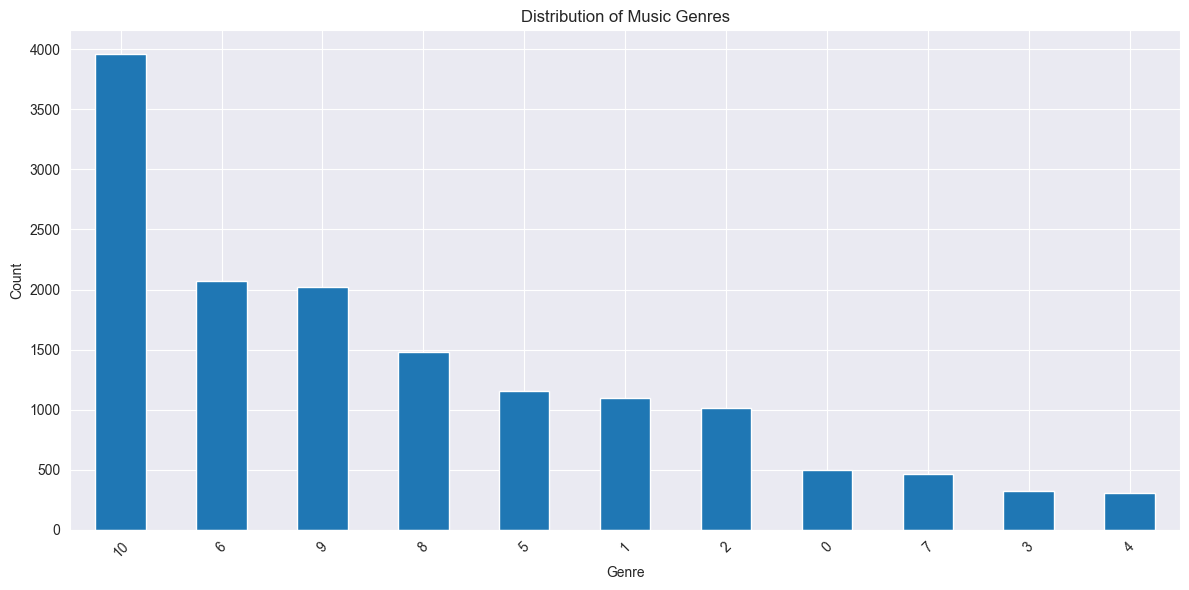

In [13]:
# Plot distribution of genres
plt.figure(figsize=(12, 6))
df['Class'].value_counts().plot(kind='bar')
plt.title('Distribution of Music Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
print(df['Class'].value_counts())

Class
10    3959
6     2069
9     2019
8     1483
5     1157
1     1098
2     1018
0      500
7      461
3      322
4      310
Name: count, dtype: int64


In [15]:
songs= df.drop(["Id",'Artist Name', 'Track Name'], axis=1)
songs.columns

Index(['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_in min/ms', 'time_signature', 'Class'],
      dtype='object')

In [16]:
numerical = ['Popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_in min/ms']
categorical = ['key', 'mode', 'time_signature']

In [17]:
df_nums = df.copy()
df_nums = df_nums[numerical]

In [18]:
# Missing Values
df_nums.isnull().sum()

Popularity            333
danceability            0
energy                  0
loudness                0
speechiness             0
acousticness            0
instrumentalness      495
liveness                0
valence                 0
tempo                   0
duration_in min/ms      0
dtype: int64

In [19]:
from sklearn.ensemble import RandomForestRegressor

# For popularity
popularity_model = RandomForestRegressor(n_estimators=100, random_state=42)
non_missing_popularity = songs[songs['Popularity'].notnull()]
missing_popularity = songs[songs['Popularity'].isnull()]

popularity_model.fit(non_missing_popularity.drop(['Popularity', 'Class'], axis=1), non_missing_popularity['Popularity'])
df_nums.loc[songs['Popularity'].isnull(), 'Popularity'] = popularity_model.predict(missing_popularity.drop(['Popularity', "Class"], axis=1))

# Similarly, for instrumentalness
instrumentalness_model = RandomForestRegressor(n_estimators=100, random_state=42)
non_missing_instrumentalness = songs[songs['instrumentalness'].notnull()]
missing_instrumentalness = songs[songs['instrumentalness'].isnull()]

instrumentalness_model.fit(non_missing_instrumentalness.drop(['instrumentalness', 'Class'], axis=1), non_missing_instrumentalness['instrumentalness'])
df_nums.loc[df_nums['instrumentalness'].isnull(), 'instrumentalness'] = instrumentalness_model.predict(missing_instrumentalness.drop(['instrumentalness', 'Class'], axis=1))


In [20]:
# Check Missing Values
df_nums.isnull().sum()

Popularity            0
danceability          0
energy                0
loudness              0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
dtype: int64

We filled the rest of the missing values above using the regression-imputation method for the Population and instrumentalness

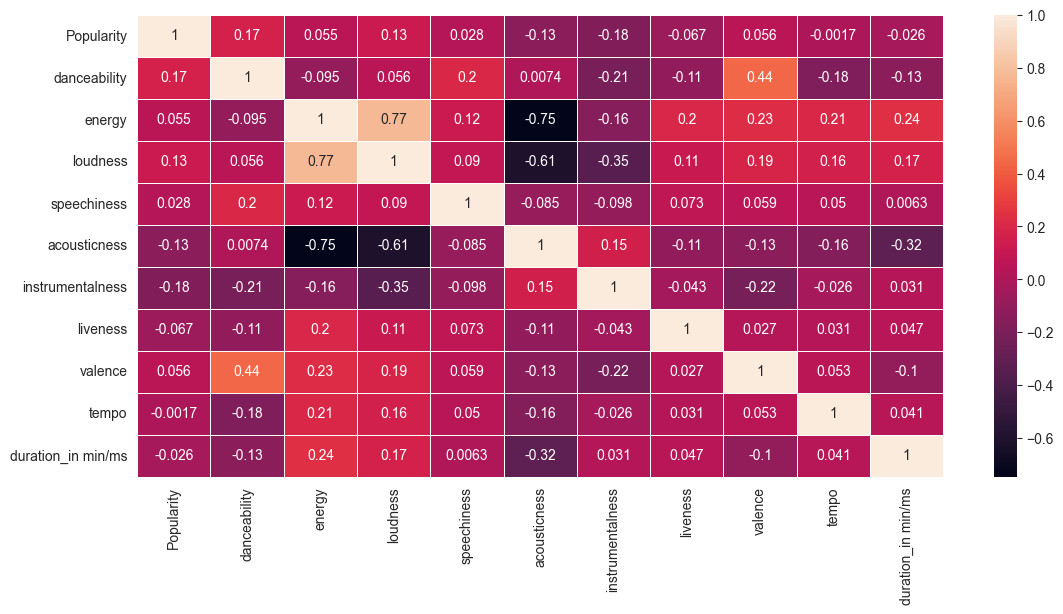

In [38]:
plt.figure(figsize=(13,6))
corr_matrix = df_nums.corr()
sns.heatmap(corr_matrix, linewidths=.7, annot=True)
plt.show()

Energy and loudness have the biggest correlation

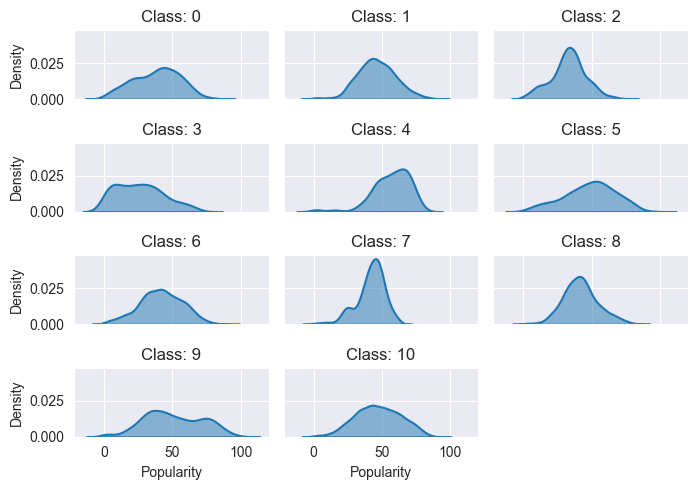

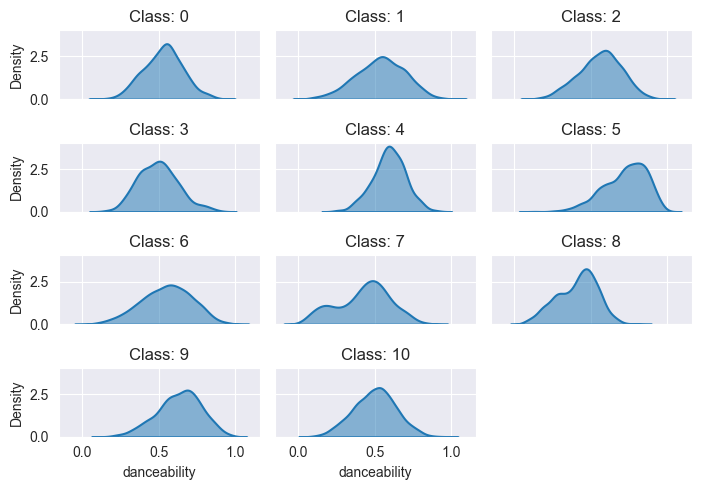

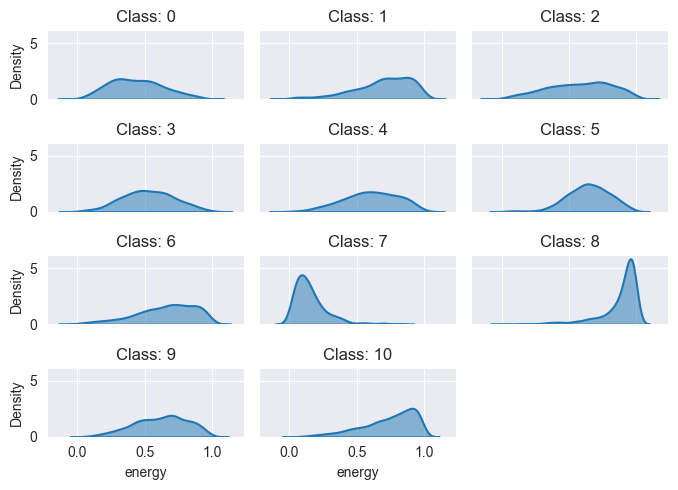

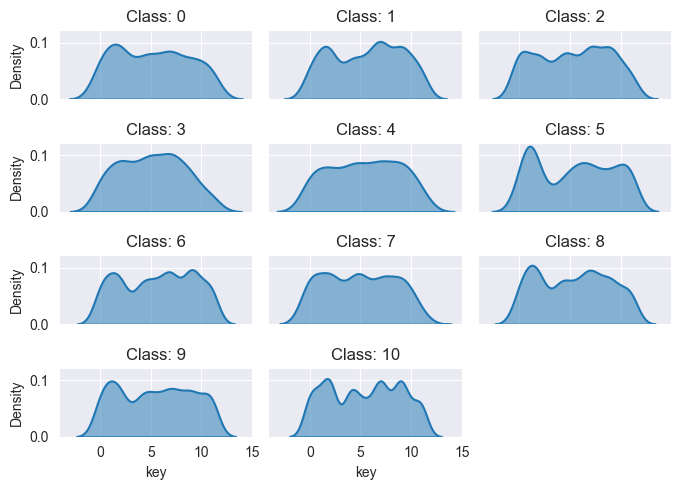

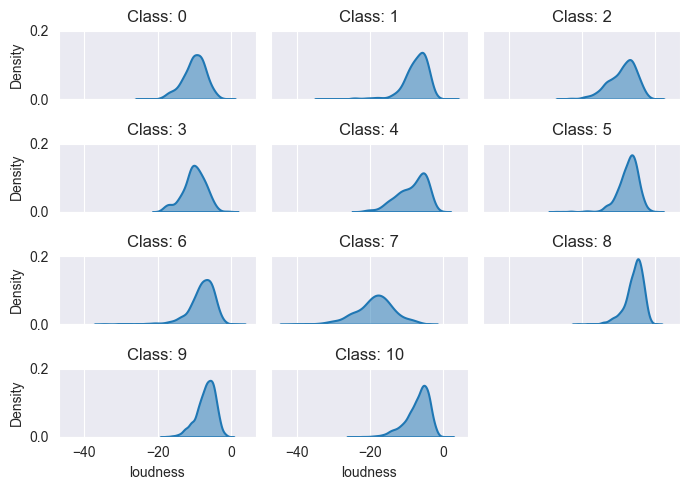

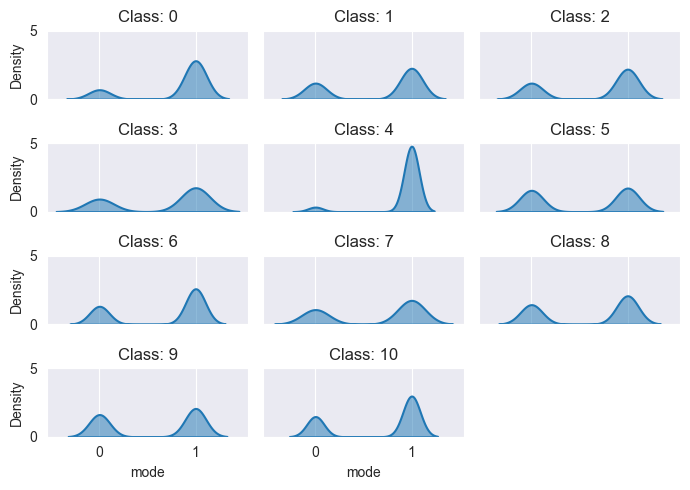

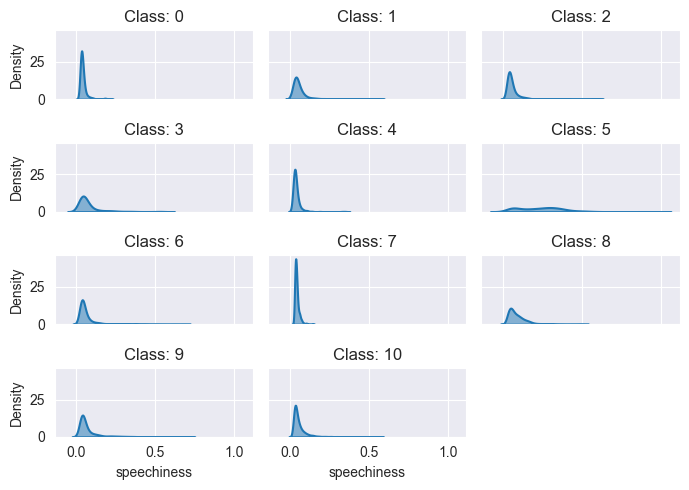

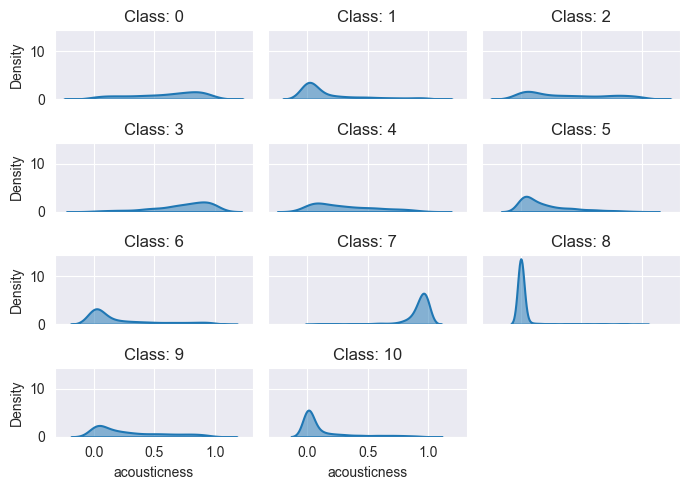

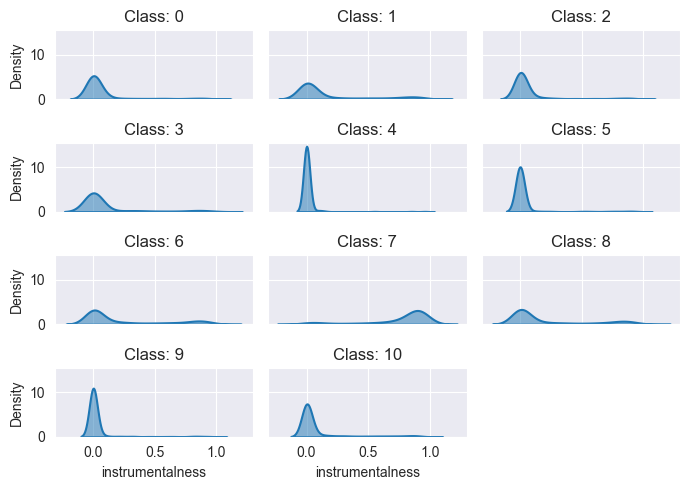

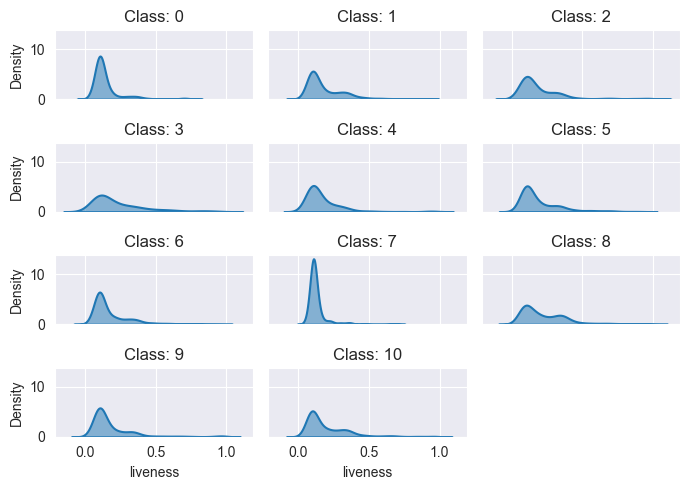

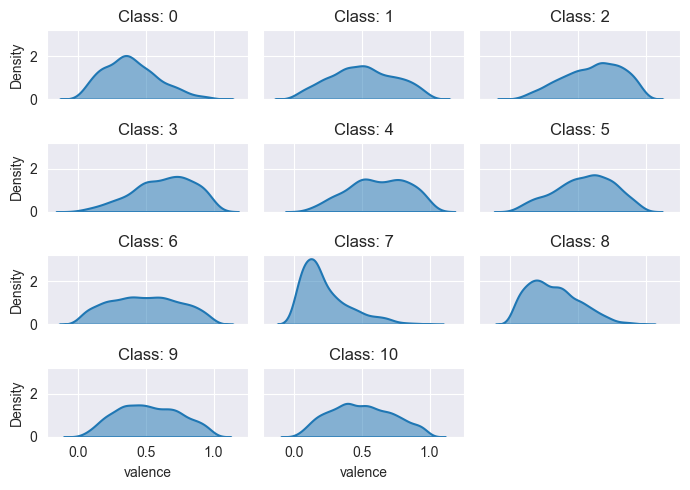

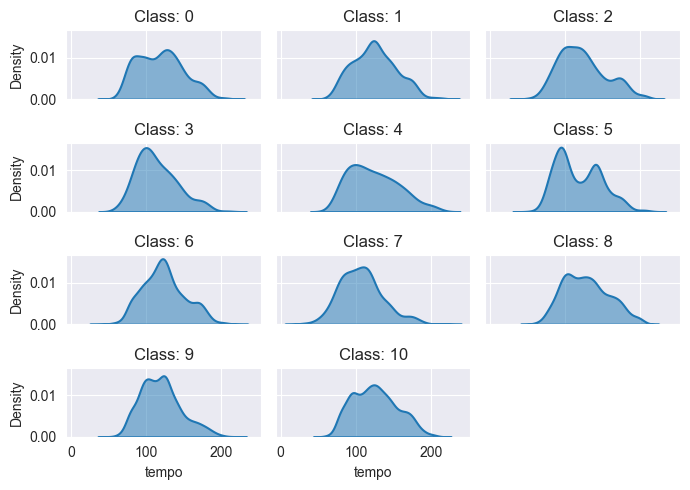

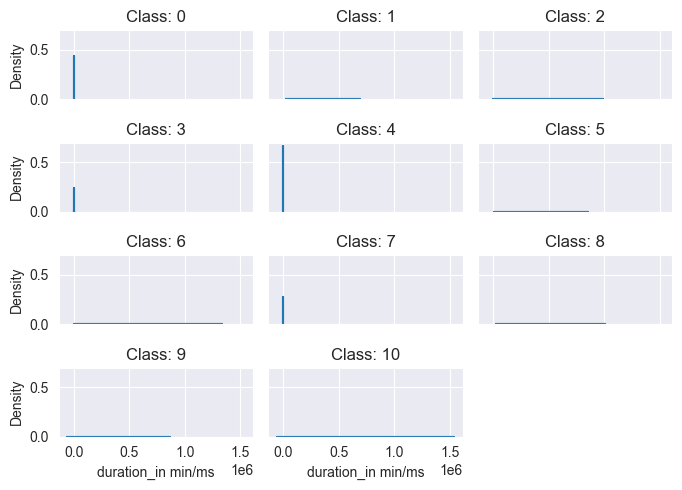

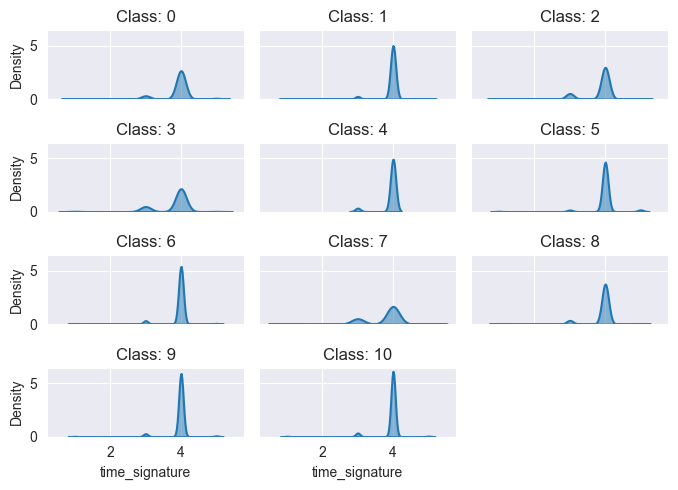

In [130]:
def feature_dist_plot(data, fearure):
  grouped_data = data.groupby('Class')
  num_classes = len(grouped_data)
  num_cols = 3
  num_rows = int(np.ceil(num_classes / num_cols))
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7,5),
                           sharex=True, sharey=True)
  axes = axes.flatten()
  for i, (name, group) in enumerate(grouped_data):
      sns.kdeplot(
          data=group, x=fearure, fill=True,
          ax=axes[i], alpha=0.5, linewidth=1.5
      )
      axes[i].set_title(f'Class: {name}', fontsize=12)
      axes[i].set_xlabel(f'{fearure}', fontsize=10)
      axes[i].set_ylabel('Density', fontsize=10)
    
          
  for j in range(num_classes, len(axes)):
      axes[j].set_visible(False)
  plt.tight_layout()
  plt.show()  
      
for i in songs.drop(['Class'], axis=1).columns:
  feature_dist_plot(songs, i)

Visualizing the distribution of each feature for each class to show variation between classes for each feature

In [21]:
df_cats = df.copy()
df_cats = df_cats[categorical]

In [22]:
df_cats.isnull().sum()

key               189
mode                0
time_signature      0
dtype: int64

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Prepare the dataframes for non-missing and missing key
non_null_df =songs.dropna()

non_missing_key = non_null_df[non_null_df['key'].notnull()]
missing_key = songs[songs['key'].isnull()]

# Drop the 'key' column and any columns with missing values for training
X_train = non_missing_key.drop(columns=['key', 'Class'])
y_train = non_missing_key['key']


# Drop the same columns in the missing dataset as were dropped in X_train
X_missing = missing_key.drop(columns=['key', 'Class'])

# Fit the RandomForest model
key_model = RandomForestClassifier(n_estimators=100, random_state=42)
key_model.fit(X_train, y_train)

# Predict the missing key values
predicted_key = key_model.predict(X_missing)

# Assign the predicted values back to the original dataframe
df_cats.loc[df_cats['key'].isnull(), 'key'] = predicted_key


In [24]:
df_cats.isnull().sum()


key               0
mode              0
time_signature    0
dtype: int64

we filled the catergorical data with the regression-imputation method for key feature

In [25]:
# Concatenate the DataFrames
X_train = pd.concat([df_nums, df_cats], axis=1)
y_train = df['Class']

In [224]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

def stratified_train(skf, model, X, y):
  lst_accu_stratified = []
  X = X.values
  y = y.values
  for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model.fit(x_train_fold, y_train_fold)
    y_test_pred = model.predict(x_test_fold)
    F1_score = metrics.f1_score(y_test_fold, y_test_pred, average='macro')
    lst_accu_stratified.append(F1_score)
  return np.mean(lst_accu_stratified)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

The above function is for the stratified splitting to keep the same distribution of classes in the train and test datasets

In [225]:
X_train.columns

Index(['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'key', 'mode', 'time_signature'],
      dtype='object')

In [26]:
X_train.isnull().sum()


Popularity            0
danceability          0
energy                0
loudness              0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
key                   0
mode                  0
time_signature        0
dtype: int64

In [27]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_f1 = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1_macro').mean()
print("Random Forest F1 Score:", rf_f1)

Random Forest F1 Score: 0.5609296290575683


In [28]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

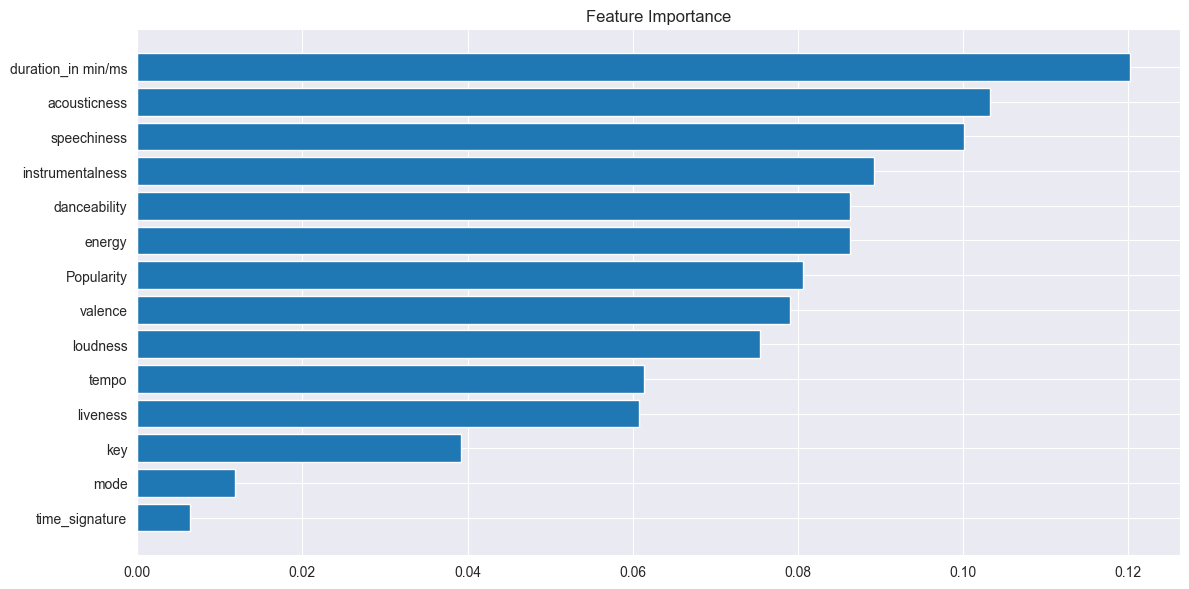

In [50]:
# Plot feature importances
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
features = rf_model.feature_names_in_
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [55]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
cv = cross_val_score(gnb, X_train, y_train, cv=5, scoring='f1_macro').mean()

In [57]:
gnb.fit(X_train, y_train)

GaussianNB()

In [58]:
cv

0.28255531461427086

In [61]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, X_train, y_train, cv=5, scoring='f1_macro').mean()
print(cv)

0.45983187748832616


In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro').mean()
print(cv)

0.29908232092400017


In [63]:
svc = SVC(probability = True)
cv = cross_val_score(svc, X_train, y_train, cv=5, scoring='f1_macro').mean()
print(cv)

0.0779263106052143


In [41]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1_macro').mean()
print(cv)

0.5622484097953231


In [42]:
from sklearn.ensemble import StackingClassifier
stacking_clf = StackingClassifier(estimators = [('rf',rf_model),('xgb',xgb)], final_estimator=LogisticRegression())

In [231]:
stratified_train(skf, stacking_clf, X_train, y_train)

0.5933514914007095

In [68]:
cv_predictions = cross_val_predict(stacking_clf, X_train, y_train, cv=3)

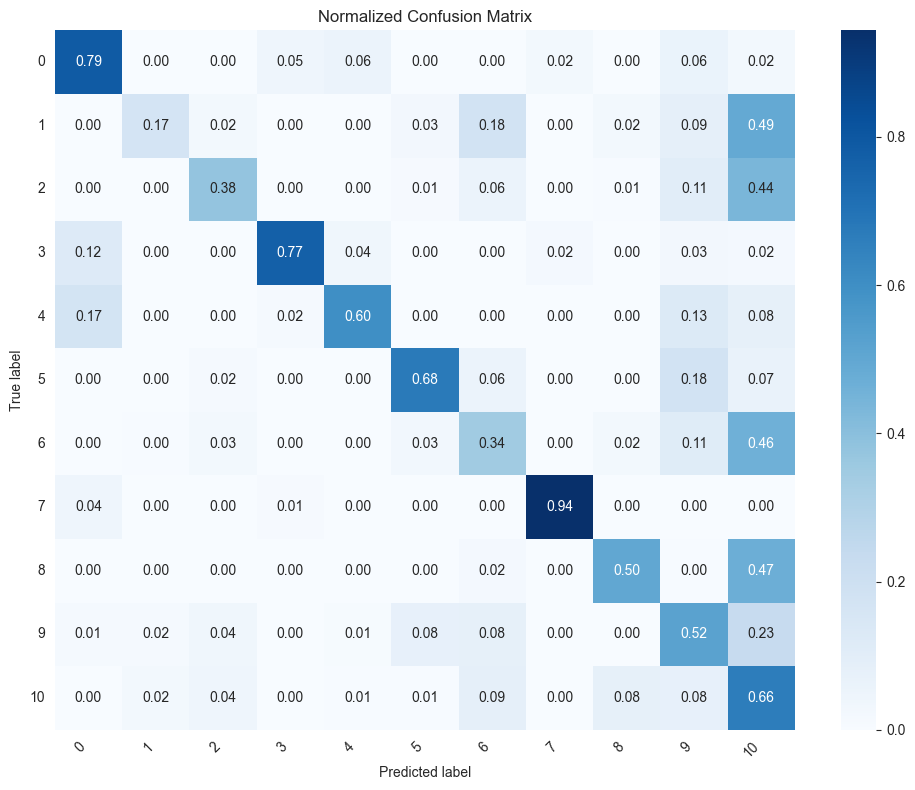

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have your true labels (y_true) and predicted labels (y_pred)
def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create a figure
    plt.figure(figsize=(10, 8))
    
    # Create a heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    
    # Set labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix')
    
    # Rotate the tick labels and set their alignment
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Tight layout to ensure all elements are visible
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Usage:
classes = sorted(df['Class'].unique())  # Get your class labels
plot_confusion_matrix(y_train, cv_predictions, classes)

# Submit

In [233]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_t...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=1, ...))],
                   final_estimator=LogisticRegression())

In [45]:
X_test = pd.read_csv('test.csv')
X_test.drop(["Id", 'Artist Name', 'Track Name'], axis=1, inplace=True)

In [250]:
popularity_model.feature_names_in_

array(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature'], dtype=object)

In [46]:

# For popularity
missing_popularity = X_test[X_test['Popularity'].isnull()]

X_test.loc[X_test['Popularity'].isnull(), 'Popularity'] = popularity_model.predict(missing_popularity.drop('Popularity', axis=1))

# Similarly, for instrumentalness
missing_instrumentalness = X_test[X_test['instrumentalness'].isnull()]

X_test.loc[X_test['instrumentalness'].isnull(), 'instrumentalness'] = instrumentalness_model.predict(missing_instrumentalness.drop('instrumentalness', axis=1))


In [47]:
missing_key = X_test[X_test['key'].isnull()]

# Drop the same columns in the missing dataset as were dropped in X_train
X_missing = missing_key.drop(columns=['key'])

# Predict the missing key values
predicted_key = key_model.predict(X_missing)

# Assign the predicted values back to the original dataframe
X_test.loc[X_test['key'].isnull(), 'key'] = predicted_key


In [255]:
stacking_clf.feature_names_in_

array(['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'key', 'mode', 'time_signature'],
      dtype='<U18')

In [48]:
X_Submit = X_test[['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'key', 'mode', 'time_signature']]

In [261]:
X_Submit.columns

Index(['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'key', 'mode', 'time_signature'],
      dtype='object')

In [262]:
y_pred = stacking_clf.predict(X_Submit)

In [264]:
submission = {'Id': pd.read_csv('test.csv')['Id'] , 'Class': y_pred}
base_submission = pd.DataFrame(data=submission)
base_submission.to_csv('base_submission.csv', index=False)

# submit whith random sample

In [57]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Assuming X is your feature matrix and y is your target variable

# Option 1: Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Option 2: Undersampling using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# # Option 3: Combine SMOTE and ENN (Edited Nearest Neighbors)
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Check the distribution after resampling
from collections import Counter
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")


Original class distribution: Counter({10: 3959, 6: 2069, 9: 2019, 8: 1483, 5: 1157, 1: 1098, 2: 1018, 0: 500, 7: 461, 3: 322, 4: 310})
Resampled class distribution: Counter({0: 310, 1: 310, 2: 310, 3: 310, 4: 310, 5: 310, 6: 310, 7: 310, 8: 310, 9: 310, 10: 310})


In [59]:
stacking_clf.fit(X_resampled, y_resampled)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_t...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=1, ...))],
                   final_estimator=LogisticRegression())

In [58]:
cv = cross_val_score(stacking_clf, X_resampled, y_resampled, cv=3, scoring='f1_macro').mean()
cv

0.5739430696549913

In [60]:
y_pred = stacking_clf.predict(X_Submit)

In [61]:
submission = {'Id': pd.read_csv('test.csv')['Id'] , 'Class': y_pred}
base_submission = pd.DataFrame(data=submission)
base_submission.to_csv('base_submission_balaned_samples_with_smote_enn.csv', index=False)